# Dropout

Dentro de los métodos de regularización, el dropout es de los más populares. Este se basa en la desconexión de neuronas dentro de la arquitectura, de tal forma que se emule un método de ensemble y esto evite el sobreajuste en los datos.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

Crearemos un conjunto de datos para clasificación en tres clases que nos servirán para ilustrar el método de dropout.

<class 'torch.Tensor'> <class 'torch.Tensor'>


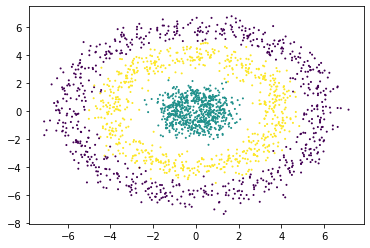

In [2]:
"""
Creación de los datos
"""
r0, r1, r2 = 1, 4, 6
k = 1000
X1 = [np.array([r0*np.cos(t),r0*np.sin(t)]) for t in range(0,k)]
X2 = [np.array([r1*np.cos(t),r1*np.sin(t)]) for t in range(0,k)]
X3 = [np.array([r2*np.cos(t),r2*np.sin(t)]) for t in range(0,k)]
X = np.concatenate((X1,X2,X3))
n,d = X.shape
Y = np.zeros(3*k)
Y[:k] += 1
Y[k:2*k] += 2
noise = np.array([np.random.normal(0,1,2) for i in range(n)])
X += 0.5*noise 

#Ejemplos formato: Tensor
X = torch.Tensor(X)
#Clases formato: LongTensor
Y = torch.LongTensor(Y)

print(type(X), type(Y))

#Seprara en train y en test
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

#Visualización de train set
plt.scatter(x_train[:,0], x_train[:,1],c=y_train,s=1)
plt.show()

### Máscaras de dropout

Para realizar el dropout podemos hacer uso de máscaras. Una máscara es un vector de la misma dimensión que las capa oculta pero que contiene 0s y 1s generados de manera aleatoria en base a una probabilidad $p$. De esta forma, los 0s anulan las neuronas a las que multiplican.

Generamos una capa oculta y aplicamos esta máscara:

In [3]:
#Capa oculta con 10 unidades
a1 = nn.Linear(2, 10)

El vector máscara del dropout puede entenderse de la siguiente forma:

$$\mu_i = \begin{cases} 0 & \text{con probabilidad } p \\ 1 & \text{con probabilidad } 1-p \end{cases}$$

Este vector se multiplica por la capa oculta para anular las neuronas correspondientes.

$$h_{dropout} = h \odot \mu$$

In [4]:
#Función que genera la máscara de manera aleatoria
get_mask = lambda p,d: torch.tensor([np.random.choice([0,1], p=[p, 1-p]) for i in range(d)])

#Generamos la máscara de 10 unidades con probabilidad 0.2
mask = get_mask(0.2, 10)
print(mask)

#Obtenemos los valores de la capa oculta
h1 = a1(X[0]).tanh()
print(h1)

#Multiplicamos la máscara por la capa oculta
print(mask*h1)

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0])
tensor([ 0.8083, -0.1925,  0.4670, -0.8857, -0.6761,  0.6004, -0.7313, -0.4875,
         0.4084, -0.3673], grad_fn=<TanhBackward>)
tensor([ 0.0000, -0.0000,  0.0000, -0.8857, -0.6761,  0.6004, -0.7313, -0.4875,
         0.4084, -0.0000], grad_fn=<MulBackward0>)


#### Usando pytorch

Las paqueterías de redes neuronales ya suelen contar con métodos para la aplicación de dropout. En el caso de pytorch se puede usar el método <i>nn.Dropout(p)</i> que se aplica a la capa y elimina las unidades con probabilidad p.

In [5]:
#Dropout en pytroch
drop = nn.Dropout(p=0.2)

#Aplicación de dropout
drop(h1)

tensor([ 1.0104, -0.2406,  0.0000, -0.0000, -0.0000,  0.7505, -0.9141, -0.0000,
         0.5105, -0.4592], grad_fn=<MulBackward0>)

## Red neuronal con dropout

Definiremos una arquitectura de red neuronal que utilice dropout en diferentes capas. Asimismo indicaremos con que probabilidad se aplicará el dropout. Este modelo será un modulo en pytorch.

In [6]:
class FeedForward(nn.Module):
    """Red Feedforward con dropout"""
    def __init__(self, n_inputs, h1_units, h2_units, n_outputs, dropout=0.5):
        super().__init__()
        #Capas de la red
        self.h1 = nn.Sequential(nn.Linear(n_inputs, h1_units), nn.ReLU())
        self.h2 = nn.Sequential(nn.Linear(h1_units, h2_units), nn.Tanh())
        self.f = nn.Sequential(nn.Linear(h2_units, n_outputs), nn.Softmax(1))
        #dropout
        self.drop = nn.Dropout(p=dropout)
        
    def forward(self, X):
        #Se puede aplicar dropout a la capa de entrada
        #X_drop = self.drop(X)
        #Calculamos la primera capa
        h1 = self.h1(X)
        #Aplicamos dropout
        h1_drop = self.drop(h1)
        #Calculamos segunda capa
        h2 = self.h2(h1_drop)
        #Aplicamos dropout
        h2_drop = self.drop(h2)
        #La capa de salida nunca lleva dropout
        f = self.f(h2_drop)
        
        return f

Definiremos dos modelos uno que usa dropout con $p=0.25$ y otro que no utiliza dropout ($p=0$).

In [7]:
#Modelo con dropout
model = FeedForward(2, 50, 100, 3, dropout=0.25)
#Modelo sin dropout
model_noDropout = FeedForward(2, 50, 100, 3, dropout=0)

#Valores para el entrenamiento
epochs = 1000
batch_size = 30
risk = nn.CrossEntropyLoss()
risk_noDrop = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer_noDropout = torch.optim.Adam(model_noDropout.parameters(), lr=0.1)

Finalmente entrenamos amnos modelos:

In [8]:
#Riesgo con dropout
total_risk = []
#Riesgo sin dropout
total_risk_noDrop = []
drop = []
no_drop = []
for t in tqdm(range(epochs)):
    perm = torch.randperm(x_train.size()[0])
    batch_risk = 0
    drop_risk = 0
    noDrop_risk = 0
    for i in range(0, x_train.size()[0], batch_size):
        idx = perm[i:i+batch_size]
        batch_x, batch_y = x_train[idx], y_train[idx]
        y_drop = model(batch_x)
        y_noDrop = model_noDropout(batch_x)

        optimizer.zero_grad()
        optimizer_noDropout.zero_grad()
        loss = risk(y_drop, batch_y)
        loss_noDropout = risk_noDrop(y_noDrop, batch_y)
        loss.backward()
        loss_noDropout.backward()
        drop_risk += loss.detach()
        noDrop_risk += loss_noDropout.detach()
        optimizer.step()
        optimizer_noDropout.step()
        
    total_risk.append(drop_risk)
    total_risk_noDrop.append(noDrop_risk)
    drop.append(accuracy_score(y_train, np.argmax(model(x_train).detach(), axis=1)))
    no_drop.append(accuracy_score(y_train, np.argmax(model_noDropout(x_train).detach(), axis=1)))

100%|██████████| 1000/1000 [02:19<00:00,  7.14it/s]


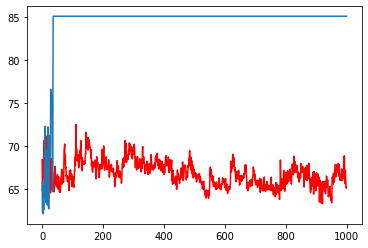

In [9]:
#Visualización de los riesgos
plt.plot(total_risk, 'r')
plt.plot(total_risk_noDrop)
plt.show()

Finalmente evaluamos ambos modelos. En primer lugar el modelo con dropout:

In [10]:
y_drop = np.argmax(model(x_test).detach(), axis=1)
print(classification_report(y_test, y_drop))

              precision    recall  f1-score   support

           0       0.50      0.76      0.60       296
           1       0.77      0.91      0.84       299
           2       0.51      0.16      0.25       305

    accuracy                           0.61       900
   macro avg       0.59      0.61      0.56       900
weighted avg       0.59      0.61      0.56       900



Y en el caso del modelo sin dropout:

In [11]:
y_no_drop = np.argmax(model_noDropout(x_test).detach(), axis=1)
print(classification_report(y_test, y_no_drop))

              precision    recall  f1-score   support

           0       0.33      1.00      0.49       296
           1       0.00      0.00      0.00       299
           2       0.00      0.00      0.00       305

    accuracy                           0.33       900
   macro avg       0.11      0.33      0.16       900
weighted avg       0.11      0.33      0.16       900



/home/mijangos/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
